<a href="https://colab.research.google.com/github/pmj-chosim/Commit-Project-2023.1.20-2023.2.28-/blob/main/2023.02.09/CV/5_instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/2023W_CV_BootCamp/4차시

/content/drive/MyDrive/2023W_CV_BootCamp/4차시


# 영상분할학습(instance segmentation-데이터셋 다운 및 클래스 설정) - #1

In [ ]:
!pip install segmentation-models-pytorch
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 27.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=d08859e12d06fd5651fc0c0d73060075dc4d106aaf122191db0e26dbc1c98870
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=991f3c946aba44222564b555c511a776061e8c7d74ecabbaf2856ce287251f81
  Stored in directory: /root/.cache/pip/

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader

In [ ]:
from PIL import Image
import numpy as np

# 보행자 데이터셋
class PennFudanDataset(torch.utils.data.Dataset):
    # 데이터셋 구성 설정
    def __init__(self, root):
        # 데이터셋 경로
        self.root = root
        
        # 이미지 및 마스크 파일 경로
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # 이미지 및 마스크 파일 경로
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        # 이미지 및 마스크 불러오기
        img = Image.open(img_path).convert("RGB").resize((256, 256))
        img = np.array(img).transpose(2, 0, 1)
        mask = Image.open(mask_path).resize((256, 256))
        mask = np.array(mask, dtype=np.float32)

        # 이미지 내 객체 카테고리 0: 배경, 123: 사람
        obj_ids = np.arange(0, 4, 1)

        # mask의 채널 확장
        masks = mask == obj_ids[:, None, None]
        masks = (masks > 0).astype(np.float32)

        # 이미지 및 레이블 정보 반환
        return {'image': img, 'mask': masks}

    # 데이터 개수
    def __len__(self):
        return len(self.imgs)

In [ ]:
train_dataset = PennFudanDataset('PennFudanPed')
valid_dataset = PennFudanDataset('PennFudanPed')
test_dataset = PennFudanDataset('PennFudanPed')

# 영상분할학습(instance segmentation-데이터출력) - #2

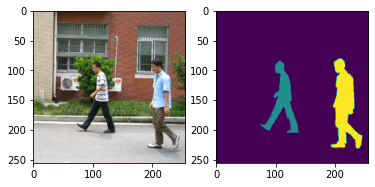

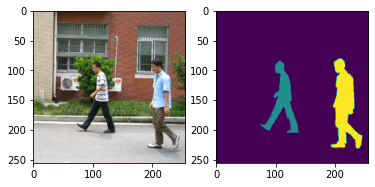

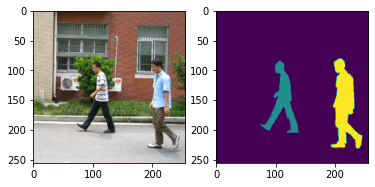

In [ ]:
# lets look at some samples

sample = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) 
plt.subplot(1,2,2)
plt.imshow(sample["mask"].argmax(0))  
plt.show()

sample = valid_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) 
plt.subplot(1,2,2)
plt.imshow(sample["mask"].argmax(0)) 
plt.show()

sample = test_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) 
plt.subplot(1,2,2)
plt.imshow(sample["mask"].argmax(0))  
plt.show()

In [ ]:
n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)

In [ ]:
class SegModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        assert image.ndim == 4

        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        assert mask.ndim == 4

        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        loss = self.loss_fn(logits_mask, mask)

        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [ ]:
model = SegModel("DeepLabV3", "efficientnet-b1", in_channels=3, out_classes=4)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

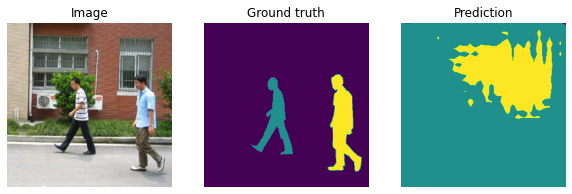

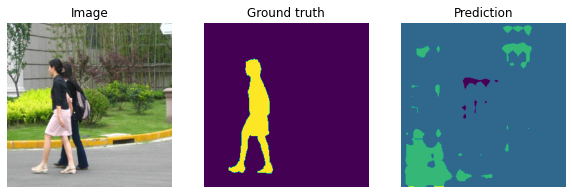

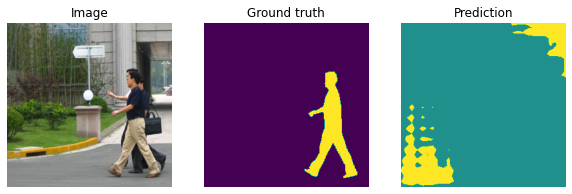

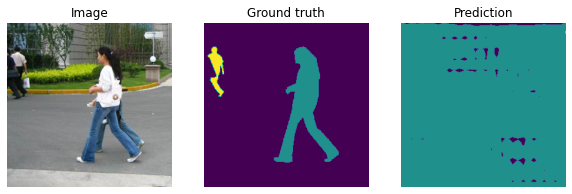

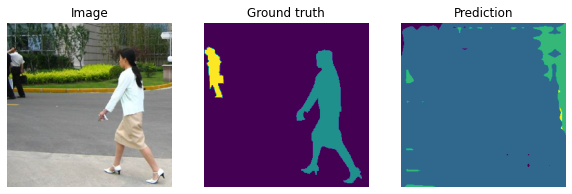

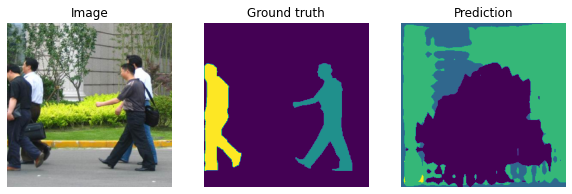

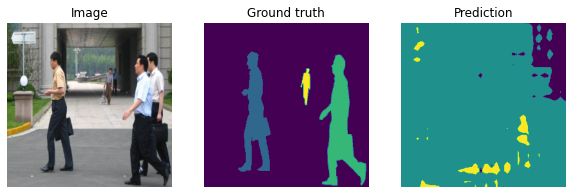

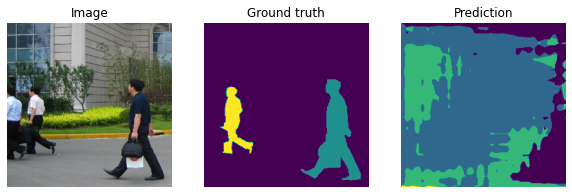

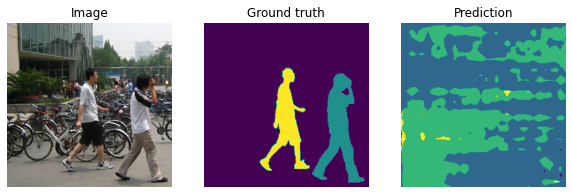

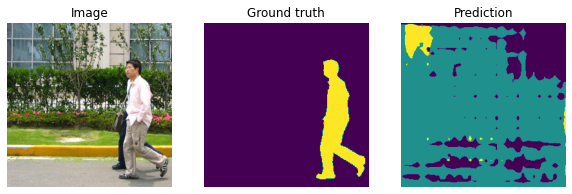

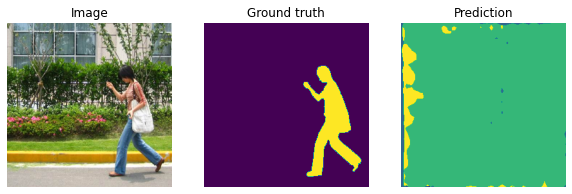

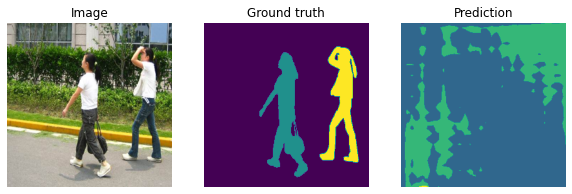

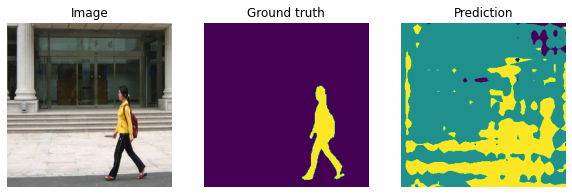

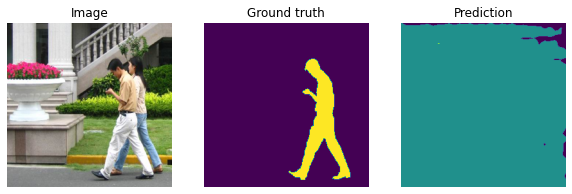

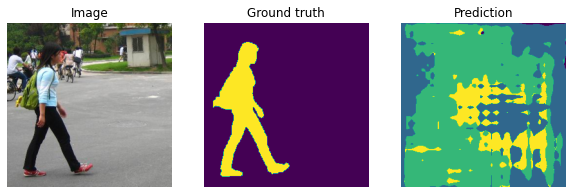

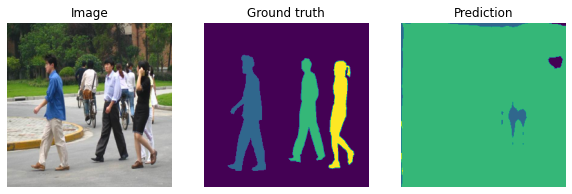

In [ ]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().argmax(0)) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().argmax(0)) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

# 영상분할학습(instance segmentation 학습수행) - #3

In [ ]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=20,
)

trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=valid_dataloader,
)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type      | Params
--------------------------------------
0 | model   | DeepLabV3 | 9.8 M 
1 | loss_fn | DiceLoss  | 0     
--------------------------------------
9.8 M     Trainable params
0         Non-trainable params
9.8 M     Tot

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


# 영상분할학습(instance segmentation-예측된 이미지 시각화) - #4

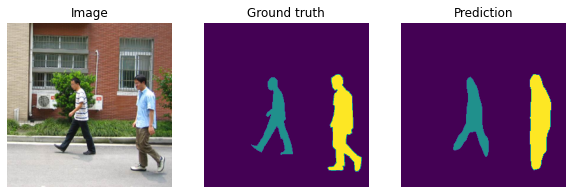

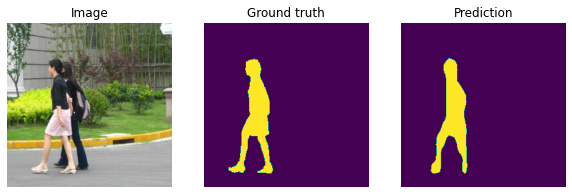

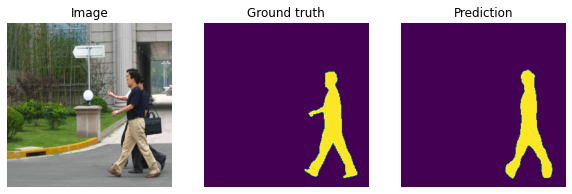

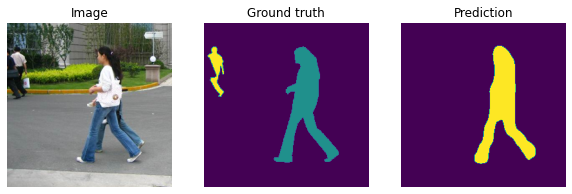

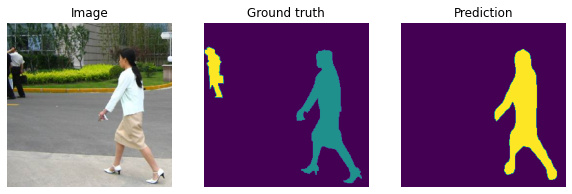

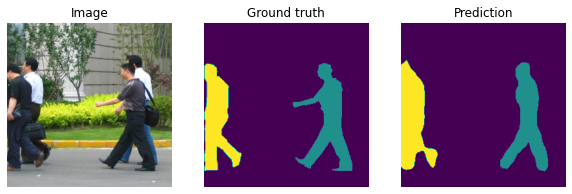

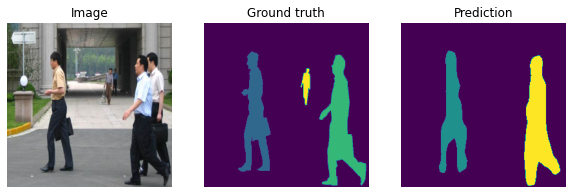

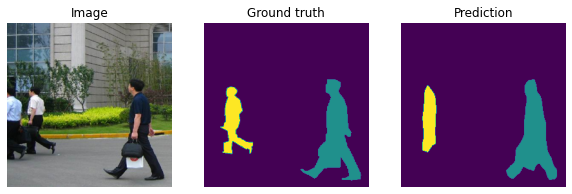

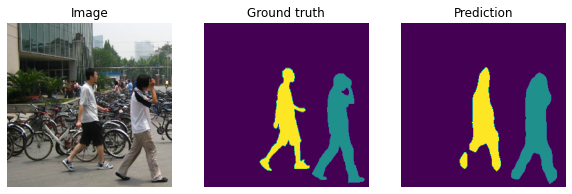

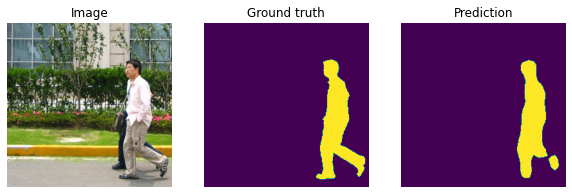

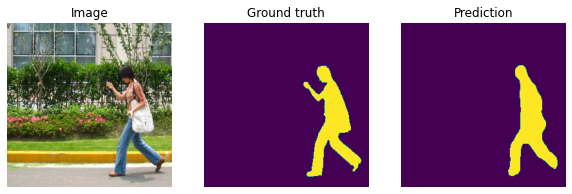

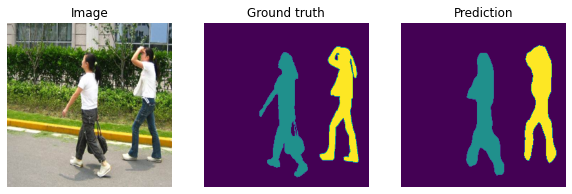

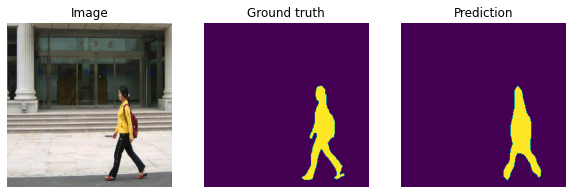

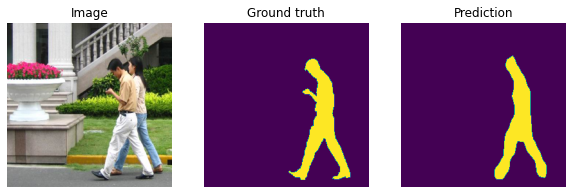

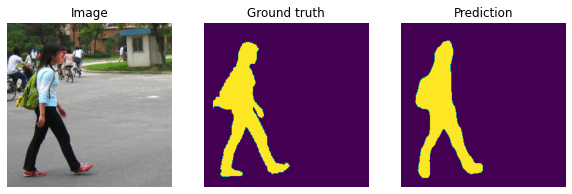

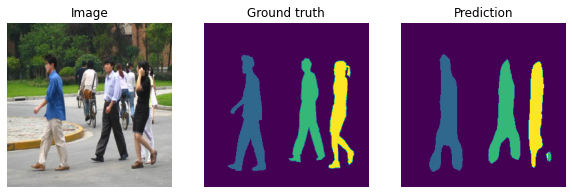

In [ ]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0)) 
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().argmax(0)) 
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().argmax(0)) 
    plt.title("Prediction")
    plt.axis("off")

    plt.show()